In [1]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client

from odc.stac import configure_rio, stac_load

/home/cy0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 11.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40137,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 11.38 GiB
Comm: tcp://127.0.0.1:39825,Total threads: 1
Dashboard: http://127.0.0.1:44449/status,Memory: 2.85 GiB
Nanny: tcp://127.0.0.1:37891,


In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2019-06",
    query={"s2:mgrs_tile": dict(eq="06VVN")},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 23 datasets


In [4]:
resolution = 10
SHRINK = 4
if client.cluster.workers[0].memory_manager.memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # running on Binder with 2Gb RAM

if SHRINK > 1:
    resolution = resolution * SHRINK

xx = stac_load(
    items,
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset> Size: 1GB
Dimensions:      (y: 1373, x: 1373, time: 23)
Coordinates:
  * y            (y) float64 11kB 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 11kB 4e+05 4e+05 4.001e+05 ... 5.096e+05 5.097e+05
    spatial_ref  int32 4B 32606
  * time         (time) datetime64[ns] 184B 2019-06-01T21:15:21.024000 ... 20...
Data variables: (12/16)
    AOT          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    B01          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    B02          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    B03          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    B04          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    B05          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    B12          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    B8A          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    SCL          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    WVP          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    visual       (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>

In [5]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    resolution=resolution,
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir,SCL


<xarray.Dataset> Size: 434MB
Dimensions:      (y: 1373, x: 1373, time: 23)
Coordinates:
  * y            (y) float64 11kB 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 11kB 4e+05 4e+05 4.001e+05 ... 5.096e+05 5.097e+05
    spatial_ref  int32 4B 32606
  * time         (time) datetime64[ns] 184B 2019-06-01T21:15:21.024000 ... 20...
Data variables:
    red          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    green        (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    blue         (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    nir          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>
    SCL          (time, y, x) uint16 87MB dask.array<chunksize=(1, 1373, 1373), meta=np.ndarray>

In [7]:
def to_float(xx):
    _xx = xx.astype("float32")
    nodata = _xx.attrs.pop("nodata", None)
    if nodata is None:
        return _xx
    return _xx.where(xx != nodata)


def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

/home/cy0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/cy0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/cy0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 

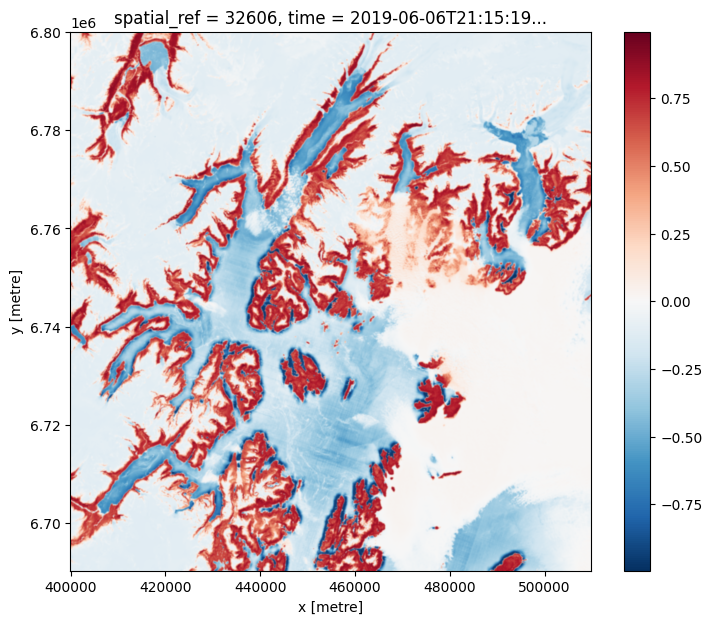

In [8]:
# like .astype(float32) but taking care of nodata->NaN mapping
nir = to_float(xx.nir)
red = to_float(xx.red)
ndvi = (nir - red) / (
    nir + red
)  # < This is still a lazy Dask computation (no data loaded yet)

# Get the 5-th time slice `load->compute->plot`
_ = ndvi.isel(time=4).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")